In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('drive/MyDrive/NFT_prediction_project/final_data')

In [3]:
!pip install keras_self_attention

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for keras-self-attention: filename=keras_self_attention-0.51.0-py3-none-any.whl size=18913 sha256=f343192760ed2692b830b63d976ed4f403205f2a3afb28c965905167759b4bfb
  Stored in directory: /root/.cache/pip/wheels/ac/13/2d/3de7c76f618a8d162884ac5b726a8c2242ad88afa370f1e62f
Successfully built keras-self-attention


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from keras.models import Sequential, load_model
from keras_self_attention import SeqSelfAttention
from keras.layers import Dense, LSTM, Dropout, Attention, Bidirectional, Flatten
from keras.regularizers import L1L2
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

In [5]:
def LSTM_baseline(X_train, y_train, epoch, train_cols=1, verbose=0):
    model = Sequential()
    model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], train_cols)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=100, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=100))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error') # Adam is generally chosen as the best overall choice
    model.fit(X_train, y_train, epochs=epoch, batch_size=32, verbose=verbose)
    return model

In [6]:
def LSTM_attention(X_train, y_train, epoch, train_cols=1, verbose=0):
    model = Sequential()
    model.add(Bidirectional(LSTM(units=100, return_sequences=True), input_shape=(X_train.shape[1], train_cols)))
    model.add(SeqSelfAttention(attention_activation='sigmoid'))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(units=100)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(units=100)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=epoch, batch_size=32, verbose=verbose)
    return model

In [7]:
def LSTM_bidirection(X_train, y_train, epoch, train_cols=1, verbose=0):
    model = Sequential()
    model.add(Bidirectional(LSTM(units=100, return_sequences=True), input_shape=(X_train.shape[1], train_cols)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(units=100, return_sequences=True)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(units=100)))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=epoch, batch_size=32, verbose=verbose)
    return model

In [8]:
def plot_real_pred_compare(real_price, pred_price, label, model_type, train_interval, cols=None):
    fig = plt.figure()
    plt.plot(real_price, color='black', label='Real Price')
    plt.plot(pred_price, color='green', label='Predicted Price')
    title = '{} with model={}, interval={}'.format(label, model_type, train_interval)
    if cols:
        cols_str = ', '.join([col for col in cols])
        title = title + '\n cols=[{}]'.format(cols_str)
    plt.title(title)
    plt.xlabel('Days')
    plt.ylabel(label + ' NFT Price')
    plt.legend()
    return fig

In [9]:
def training_and_plot(nft_label, train_interval, model_type, model=None, epoch=100):
    data = pd.read_csv(nft_label + '.csv', index_col=0)['Average USD'].values.reshape(-1,1)
    # scale the data to [0,1]
    sc = MinMaxScaler(feature_range=(0, 1))
    data_scaled = sc.fit_transform(data)

    # split 70% for training, 30% for testing
    data_size = len(data)
    train_size = int(data_size * 0.7)
    test_size = data_size - train_size
    train_data, test_data = data_scaled[0:train_size], data_scaled[train_size:len(data)]

    # generate training data
    X_train = np.array([train_data[i:i+train_interval] for i in range(len(train_data)-train_interval)]) 
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

    y_train = np.array([train_data[i+train_interval] for i in range(len(train_data)-train_interval)])

    model = model
    
    if not model:
        if model_type == 'baseline':
            model = LSTM_baseline(X_train, y_train, epoch)
        elif model_type == 'attention':
            model = LSTM_attention(X_train, y_train, epoch)
        elif model_type == 'bidirection':
            model = LSTM_bidirection(X_train, y_train, epoch)
        model.save('models/{}_{}_{}.h5'.format(nft_label, model_type, train_interval))
    real_price = data[data_size-test_size:]
    inputs = data[data_size - test_size - train_interval:]
    inputs = inputs.reshape(-1, 1)
    inputs = sc.transform(inputs)

    X_test = [inputs[i - train_interval:i, 0] for i in range(train_interval, test_size + train_interval)]

    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    pred_price = model.predict(X_test)
    pred_price = sc.inverse_transform(pred_price)

    fig = plot_real_pred_compare(real_price, pred_price, nft_label, model_type, train_interval)
    return {'model': model, 'pred_price': pred_price, 'real_price': real_price, 'fig': fig}

In [10]:
def training_and_plot_multi_cols(nft_label, train_interval, model_type, cols, model=None, epoch=100):
    col_size = len(cols)
    data = pd.read_csv(nft_label + '.csv', index_col=0)[cols].values.reshape(-1, col_size)
    sc = MinMaxScaler(feature_range=(0, 1))
    data_scaled = sc.fit_transform(data)
    data_size = len(data)
    train_size = int(data_size * 0.7)
    test_size = data_size - train_size
    train_data, test_data = data_scaled[0:train_size], data_scaled[train_size:len(data)]

    train_interval = 30
    X_train = np.array([train_data[i:i+train_interval] for i in range(len(train_data)-train_interval)]) 
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], col_size))

    sc_target = MinMaxScaler(feature_range=(0, 1))
    target_data = pd.read_csv(nft_label + '.csv', index_col=0)['Average USD'].values.reshape(-1,1)
    target_scaled = sc_target.fit_transform(target_data)

    y_train = np.array([target_scaled[i+train_interval] for i in range(len(train_data)-train_interval)])

    model = model
    print(model)
    if model is None:
        if model_type == 'baseline':
            model = LSTM_baseline(X_train, y_train, epoch, col_size)
        elif model_type == 'attention':
            model = LSTM_attention(X_train, y_train, epoch, col_size)
        elif model_type == 'bidirection':
            model = LSTM_bidirection(X_train, y_train, epoch, col_size)
        model.save('models_dropna/{}_{}_{}.h5'.format(nft_label, model_type, train_interval))
    real_price = target_data[data_size-test_size:]
    inputs = data[data_size - test_size - train_interval:]
    inputs = inputs.reshape(-1, col_size)
    inputs = sc.transform(inputs)
    X_test = [inputs[i - train_interval:i] for i in range(train_interval, test_size + train_interval)]
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], col_size))
    pred_price = model.predict(X_test)
    pred_price = sc_target.inverse_transform(pred_price)
    fig = plot_real_pred_compare(real_price, pred_price, nft_label, 'baseline', train_interval, cols)
    return {'model': model, 'pred_price': pred_price, 'real_price': real_price, 'cols': cols, 'fig': fig}


6/6 [==============================] - 2s 62ms/step


<ipython-input-8-1baddddb7885>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


6/6 [==============================] - 2s 39ms/step


<ipython-input-8-1baddddb7885>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


6/6 [==============================] - 2s 81ms/step


<ipython-input-8-1baddddb7885>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


6/6 [==============================] - 2s 127ms/step


<ipython-input-8-1baddddb7885>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


6/6 [==============================] - 3s 64ms/step


<ipython-input-8-1baddddb7885>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


6/6 [==============================] - 3s 111ms/step


<ipython-input-8-1baddddb7885>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


6/6 [==============================] - 6s 234ms/step


<ipython-input-8-1baddddb7885>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


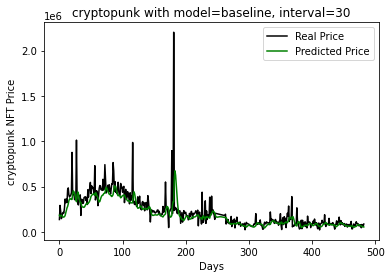

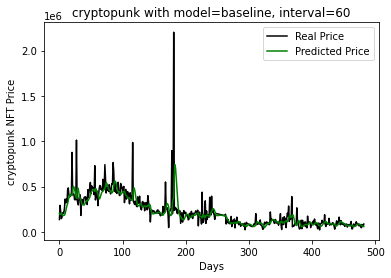

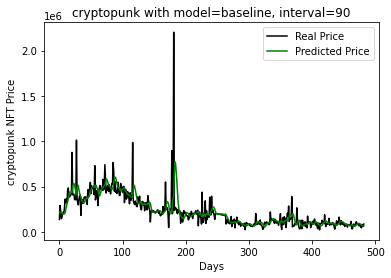

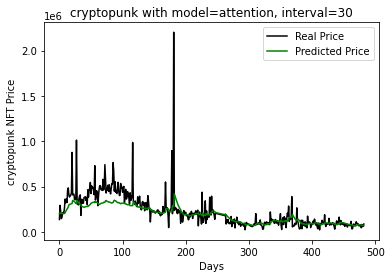

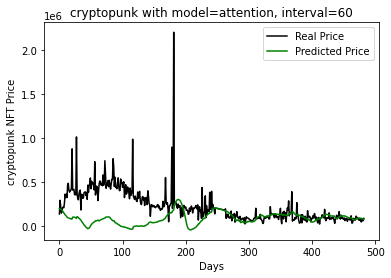

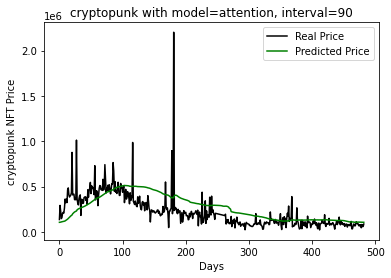

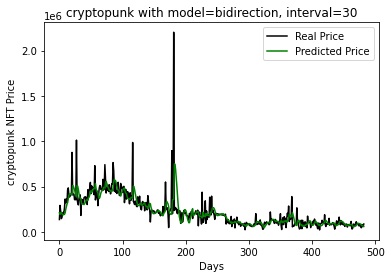

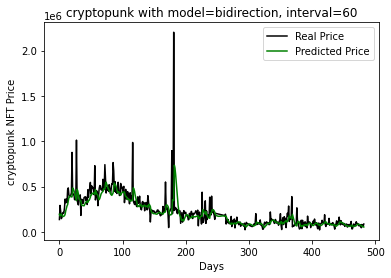

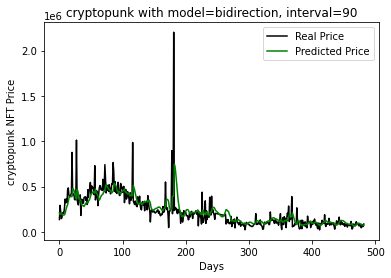

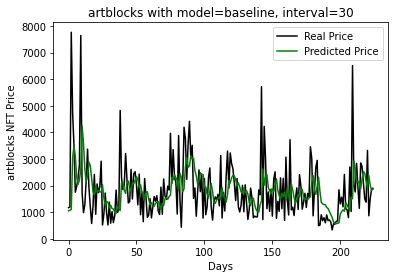

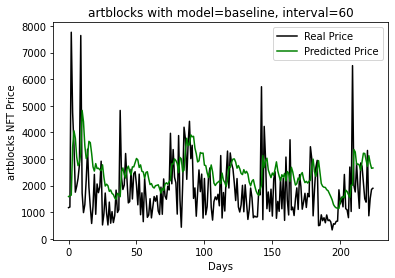

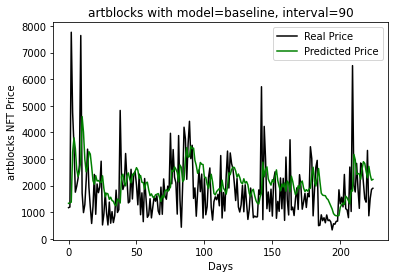

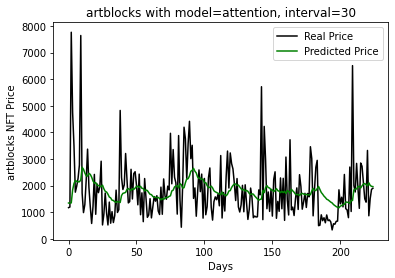

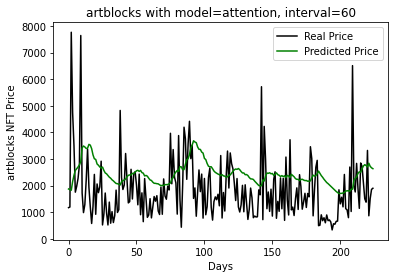

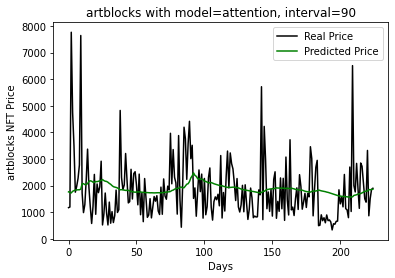

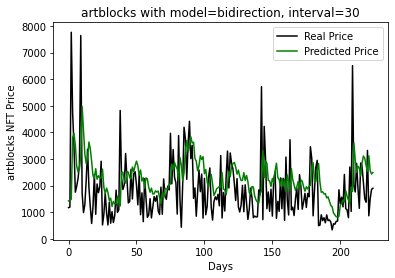

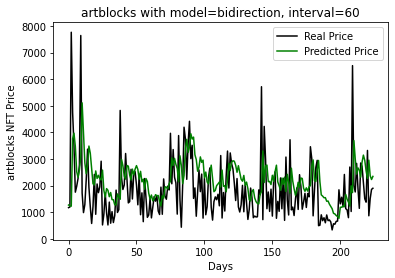

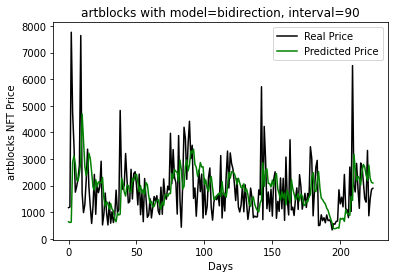

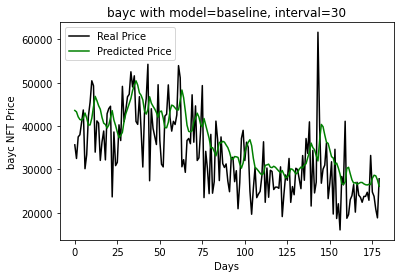

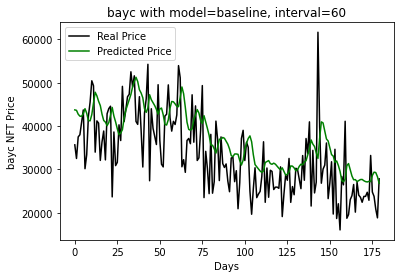

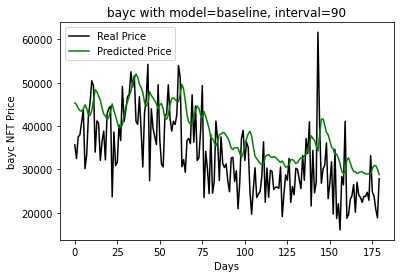

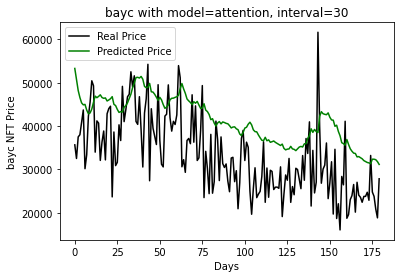

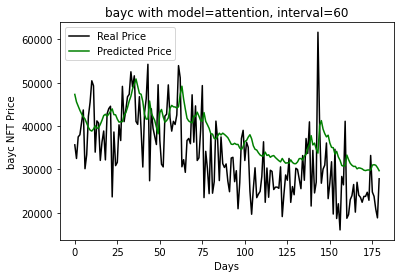

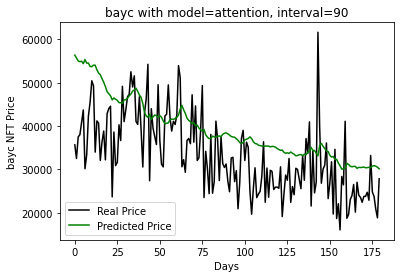

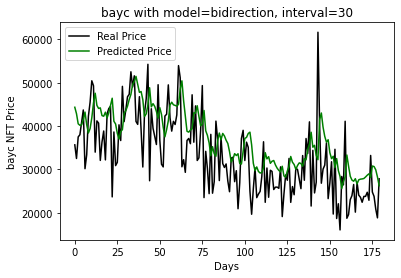

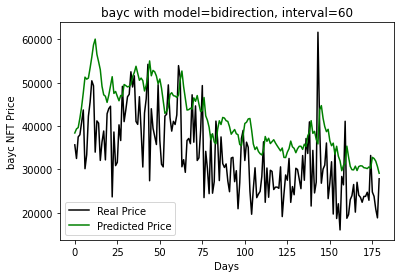

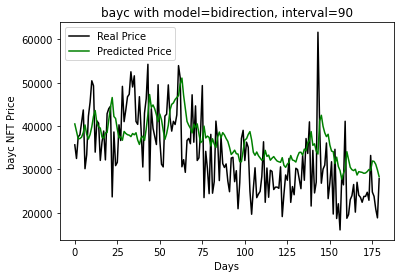

In [12]:
# we assume default epoch is 100, since epoch=100 could have a good performance
epoch = 100
cols = ['Average USD']
nfts = ['cryptopunk', 'artblocks', 'bayc']
model_type = ['baseline', 'attention', 'bidirection']
train_intervals = [30,60,90]

results = {}

def train_all(cols=None, model_path=None):
    for nft in nfts:
        nft_figure_path = '../figures/{}/'.format(nft)
        if nft not in os.listdir('../figures'):
            os.mkdir(nft_figure_path)
        if cols:
            cols_str = '_'.join([col for col in cols])
            cols_str = cols_str.replace(' ', '')
            fig_path = nft_figure_path + cols_str
            if not os.path.exists(fig_path):
                os.mkdir(fig_path)
        results[nft] = {}
        for model in model_type:
            results[nft][model] = {}
            for interval in train_intervals:
                # print(model_path+'{}_{}_{}.h5'.format(nft, model, interval))
                lstm_model = None
                if model != 'attention':
                    lstm_model = None if not model_path else load_model(model_path+'{}_{}_{}.h5'.format(nft, model, interval))
                else:
                    lstm_model = None if not model_path else load_model(model_path+'{}_{}_{}.h5'.format(nft, model, interval), custom_objects={'SeqSelfAttention': SeqSelfAttention})
                if len(cols) == 1:
                    results[nft][model][interval] = training_and_plot(nft_label=nft, train_interval=interval, model_type=model, model=lstm_model, epoch=epoch)
                else:
                    results[nft][model][interval] = training_and_plot_multi_cols(nft_label=nft, train_interval=interval, model_type=model, model=lstm_model, cols=cols, epoch=epoch)
                if not model_path:
                    results[nft][model][interval]['fig'].savefig(fig_path+'/'+'{}_{}.png'.format(model, interval))

train_all(cols=cols, model_path='../final_data/models/')

In [15]:
def price_dropna(arr):
    mask = np.logical_not(np.isnan(arr))
    filtered_arr = arr[mask]
    return filtered_arr.reshape(-1,1)
import sklearn.metrics as metrics

def binary_accuracy(real_price, pred_price):
  right_pred_count = 0
  for i in range(1, len(real_price)):
    if(real_price[i] > real_price[i-1] and pred_price[i] > real_price[i-1]) or (real_price[i] < real_price[i-1] and pred_price[i] < real_price[i-1]) or (real_price[i] == real_price[i-1] and pred_price[i] == real_price[i-1]):
      right_pred_count += 1
  return right_pred_count/real_price.size

def evaluation(nft, model, interval):
#   standard_metrics = pd.Series()
  real_price = price_dropna(results[nft][model][interval]['real_price'])
  pred_price = price_dropna(results[nft][model][interval]['pred_price'])
  print('MAE:            {}'.format(round(metrics.mean_absolute_error(real_price, pred_price),2)))
  print('MSE:            {}'.format(round(metrics.mean_squared_error(real_price, pred_price),2)))
  print('MedAE:          {}'.format(round(metrics.median_absolute_error(real_price, pred_price),2)))
  print('Binary Accuary: {}'.format(round(binary_accuracy(real_price, pred_price),2)))
#   standard_metrics.loc['MAE'] = round(metrics.mean_absolute_error(real_price, pred_price),2)
#   standard_metrics.loc['MSE'] = round(metrics.mean_squared_error(real_price, pred_price),2)
#   standard_metrics.loc['MedAE'] = round(metrics.median_absolute_error(real_price, pred_price),2)
#   standard_metrics.loc['Binary Accuracy'] = round(binary_accuracy(real_price, pred_price),2)
#   print(standard_metrics)

for nft in nfts:
  for model in model_type:
    for interval in train_intervals:
      print("Metrics for ", nft, "-", model, "-", interval)
      evaluation(nft, model, interval)


Metrics for  cryptopunk - baseline - 30
MAE:            60599.96
MSE:            16836991349.28
MedAE:          33141.52
Binary Accuary: 0.62
Metrics for  cryptopunk - baseline - 60
MAE:            56948.16
MSE:            16035706483.0
MedAE:          30538.56
Binary Accuary: 0.65
Metrics for  cryptopunk - baseline - 90
MAE:            58303.01
MSE:            16245343111.82
MedAE:          28851.57
Binary Accuary: 0.64
Metrics for  cryptopunk - attention - 30
MAE:            65228.73
MSE:            18663151234.82
MedAE:          30717.4
Binary Accuary: 0.62
Metrics for  cryptopunk - attention - 60
MAE:            158302.11
MSE:            61662977052.74
MedAE:          64453.12
Binary Accuary: 0.59
Metrics for  cryptopunk - attention - 90
MAE:            112270.93
MSE:            26261152842.01
MedAE:          94122.4
Binary Accuary: 0.54
Metrics for  cryptopunk - bidirection - 30
MAE:            57831.84
MSE:            16341661121.18
MedAE:          29891.13
Binary Accuary: 0.64
M

In [ ]:
# def mean_squared_error(real_price, pred_price):
#   squared_error = np.square(real_price - pred_price) 
#   sum_squared_error = np.sum(squared_error)
#   mse_loss = sum_squared_error / real_price.size
#   return mse_loss

# def mean_abs_error(real_price, pred_price):
#   abs_error = np.absolute(real_price - pred_price) 
#   sum_abs_error = np.sum(abs_error)
#   mae_loss = sum_abs_error / real_price.size
#   return mae_loss

# lstm_mse = mean_squared_error(real_price_1, pred_price_1)
# bi_lstm_mse = mean_squared_error(real_price_2, pred_price_2)
# lstm_attention_mse = mean_squared_error(real_price_3, pred_price_3)

# print(f"Mean squared error for LSTM: ", lstm_mse)
# print(f"Mean squared error for Bi-LSTM: ", bi_lstm_mse)
# print(f"Mean squared error for LSTM with attention: ", lstm_attention_mse)

# lstm_mae = mean_abs_error(real_price_1, pred_price_1)
# bi_lstm_mae = mean_abs_error(real_price_2, pred_price_2)
# lstm_attention_mae = mean_abs_error(real_price_3, pred_price_3)

# print(f"Mean absolute error for LSTM: ", lstm_mae)
# print(f"Mean absolute error for Bi-LSTM: ", bi_lstm_mae)
# print(f"Mean absolute error for LSTM with attention: ", lstm_attention_mae)
